# Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

# First program

## Parsing files

In [48]:
bbs = {}

#Reading basic block data
with open("temp/breaker_code.txt") as fIn:
    for line in tqdm.tqdm(fIn, desc='Read file'):
        #line start with "@" symbols the begging of a new basic block
        if line[0] == "@":
            bb_name = line.split()[-1].rstrip(":")
            bbs[bb_name] = []
        else:
            bbs[bb_name].append(line.split("=")[0].rstrip())

Read file: 20871it [00:00, 1627124.88it/s]


In [49]:
bbs_energy = {}

#Reading basic block data
with open("bin_to_dec_results/breaker_final_energy.txt") as fIn:
    for line in tqdm.tqdm(fIn, desc='Read file'):
        #line start with "@" symbols the begging of a new basic block
        line = line.split(":")
        bb_name = line[0].split()[-1]
        bbs_energy[bb_name] = float(line[-1].strip())

Read file: 2957it [00:00, 978659.90it/s]


In [50]:
bbs_df = pd.DataFrame({"bb_name": bbs.keys(), "bb": bbs.values()})
bbs_energy_df = pd.DataFrame({"bb_name": bbs_energy.keys(), "energy": bbs_energy.values()})

df = bbs_df.merge(bbs_energy_df, on="bb_name", how="inner")
print(f"Number of basic blocks with energies for program: {len(df)}")

Number of basic blocks with energies for program: 2957


## Analysis

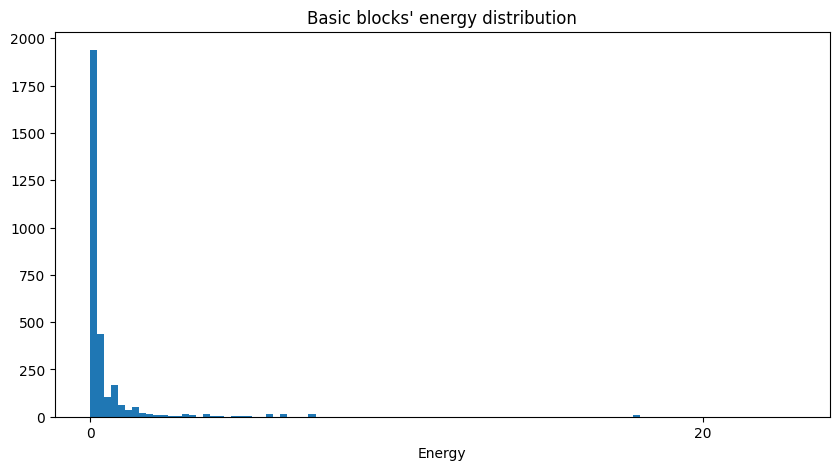

In [14]:
x_ticks = np.arange(df.energy.min(), df.energy.max(), 20)

plt.figure(figsize=(10, 5))
plt.hist(df.energy, bins=100)
plt.title("Basic blocks' energy distribution")
plt.xlabel("Energy")
plt.xticks(x_ticks)
plt.show()

We have one outlier which we throw away

In [19]:
grouped_df = df.groupby(df["bb"].map(tuple))["energy"].apply(list).reset_index()
grouped_df

,bb,energy
0,"(add $0x18, %rsp, mov %r13, %rax, popq %rbx, ...","[0.35243471772842716, 0.4812207255609908, 0.0,..."
1,"(add $0x18, %rsp, retq)","[0.01888333437389588, 0.1336714974321676, 0.13..."
2,"(add $0x1d0, %rsp, popq %rbp, popq %r12, pop...","[0.21537422452452065, 1.8454019891077442, 0.41..."
3,"(add $0x38, %rsp, mov %r12d, %eax, popq %rbx,...",[0.0]
4,"(add $0x38, %rsp, mov %r14d, %eax, popq %rbx,...",[0.0]
...,...,...
474,"(xor %ecx, %ecx, movl -0x510(%rbp), %edx, cmp...","[1.3153388730701665, 0.0, 0.0, 0.0]"
475,"(xor %edx, %edx, xor %esi, %esi, mov %rbx, %rd...",[0.0]
476,"(xor %esi, %esi, mov %r13, %rdi, callq 0xffff...","[0.6657063170368209, 5.703963342277551, 1.2881..."
477,"(xor %r12d, %r12d, nop, movl %fs:0x18, %eax, ...",[0.0]


In [42]:
from numpy import mean
data = {'BB': [],
        'average_energy': [],
        'occurences':[]
        }
 
# Create DataFrame

averaged_energies = pd.DataFrame(data)
for index, row in grouped_df.iterrows():
        new_df = pd.DataFrame({'BB':[row['bb']],'average_energy':mean(row['energy']),'occurences':len(row['energy'])})
        averaged_energies= pd.concat([averaged_energies, new_df], axis=0, ignore_index=True)
averaged_energies

,BB,average_energy,occurences
0,"(add $0x18, %rsp, mov %r13, %rax, popq %rbx, ...",0.166731,5.0
1,"(add $0x18, %rsp, retq)",0.033847,44.0
2,"(add $0x1d0, %rsp, popq %rbp, popq %r12, pop...",0.723571,4.0
3,"(add $0x38, %rsp, mov %r12d, %eax, popq %rbx,...",0.000000,1.0
4,"(add $0x38, %rsp, mov %r14d, %eax, popq %rbx,...",0.000000,1.0
...,...,...,...
474,"(xor %ecx, %ecx, movl -0x510(%rbp), %edx, cmp...",0.328835,4.0
475,"(xor %edx, %edx, xor %esi, %esi, mov %rbx, %rd...",0.000000,1.0
476,"(xor %esi, %esi, mov %r13, %rdi, callq 0xffff...",2.236491,4.0
477,"(xor %r12d, %r12d, nop, movl %fs:0x18, %eax, ...",0.000000,1.0


In [54]:
clean_energies =averaged_energies[averaged_energies['average_energy']>0].reset_index()
clean_energies

,index,BB,average_energy,occurences
0,0,"(add $0x18, %rsp, mov %r13, %rax, popq %rbx, ...",0.166731,5.0
1,1,"(add $0x18, %rsp, retq)",0.033847,44.0
2,2,"(add $0x1d0, %rsp, popq %rbp, popq %r12, pop...",0.723571,4.0
3,6,"(add $0x8, %rsp, mov %r13, %rax, popq %rbx, p...",0.352435,1.0
4,8,"(add $0x8, %rsp, popq %rbx, popq %rbp, popq ...",0.086887,4.0
...,...,...,...,...
367,472,"(xor %eax, %eax, pxor %xmm0, %xmm0, movq $0x0...",2.060203,4.0
368,473,"(xor %ebx, %ebx, jmp 0xffffffffffffdf2e)",0.060153,4.0
369,474,"(xor %ecx, %ecx, movl -0x510(%rbp), %edx, cmp...",0.328835,4.0
370,476,"(xor %esi, %esi, mov %r13, %rdi, callq 0xffff...",2.236491,4.0


In [44]:
clean_energies.to_csv('clean_data.csv')